In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
# torch.cuda.is_available()
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

In [2]:
image_dim = 16
true_psf_stdev = 1.5
true_background = 10000
true_flux_scale = 80000
true_flux_shape = 20000

TruePrior = StarPrior(max_objects = 10,
                      image_height = image_dim,
                      image_width = image_dim,
                      flux_scale = true_flux_scale,
                      flux_shape = true_flux_shape)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

image 1 
count
 3 
total flux
 262624.59375 
loc
 [[10.748174   1.6214237]
 [ 2.797306  14.957111 ]
 [ 8.110377   3.989345 ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]] 




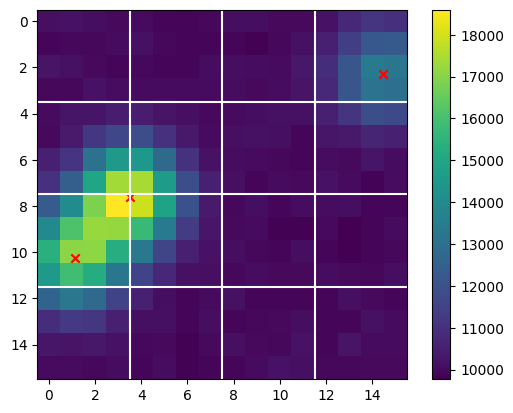

In [3]:
for i in range(1):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    tmp = img.imshow(images[i].cpu(), cmap = 'viridis')
    _ = fig.colorbar(tmp)
    _ = img.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                    true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
    _ = img.vlines(x=image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
    _ = img.vlines(x=2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
    _ = img.vlines(x=3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
    _ = img.hlines(y=image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
    _ = img.hlines(y=2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
    _ = img.hlines(y=3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

We'll assume that the image background, PSF standard deviation, and flux prior parameters are all known.

In [4]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 6,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      flux_scale = true_flux_scale,
                      flux_shape = true_flux_shape,
                      pad = 4)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MHKernel = MetropolisHastings(num_iters = 100,
                              locs_stdev = 0.1,
                              features_stdev = 2500)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [5]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 1000,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 3
True total flux: 262624.59375

Starting the tile samplers...
iteration 5, temperature = 0.01796421781182289
iteration 10, temperature = 0.7845088839530945
Done!

summary
number of SMC iterations: 10
posterior mean count by tile:
tensor([[0.0363, 1.0000],
        [1.9983, 0.0000]], device='cuda:4')


Now we instantiate an `Aggregate` object with the tile-level results from above:

In [6]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.features,
                smc.weights_intercount)

### A brief tangent: lightweight mixture resampling

In [7]:
# agg.resample(multiplier = 5)
# agg.log_density_children = agg.compute_log_density()
# agg.join(axis = 0)
# agg.log_density_parents = agg.compute_log_density()
# agg.weights = (agg.log_density_parents - agg.log_density_children).softmax(-1)
# agg.resample(multiplier = 1/5)
# # TODO: resample log_density_children in agg.resample(multiplier = 1/5)
# agg.log_density_parents = agg.compute_log_density()
# agg.weights = (agg.log_density_parents - agg.log_density_children).softmax(-1)

### End of brief tangent

We run the aggregation procedure to obtain image-level catalogs:

In [8]:
agg.run()

We compute the posterior mean number of light sources:

In [9]:
agg.posterior_mean_counts

tensor([[3.0000]], device='cuda:4')

And we compute the posterior mean total flux:

In [10]:
agg.posterior_mean_total_flux

tensor([[261497.0938]], device='cuda:4')

Plot the locations from the catalog with the largest weight:

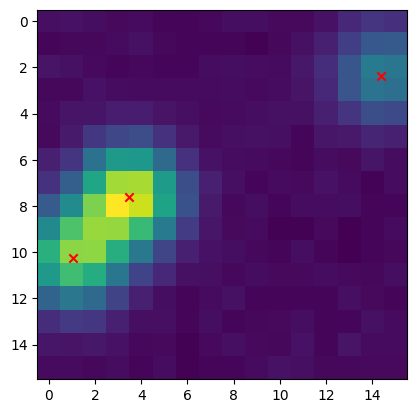

In [11]:
index = agg.weights.squeeze().argmax()
tmp = agg.locs.squeeze()[index][:agg.counts.squeeze()[index].item()]
fig, img = plt.subplots(1,1)
_ = img.imshow(images[0].cpu())
_ = img.scatter(tmp[:agg.counts.squeeze()[index],1].cpu() - 0.5,
                tmp[:agg.counts.squeeze()[index],0].cpu() - 0.5, color = 'red', marker='x')
plt.show()